In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [2]:
# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.imaging.kirchhoff import Kirchhoff
from pyfrac.utils.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage
from pyfrac.visualisation.eventimages import locimage3d

# SETUP - MODEL, REC GEOM, SOURCES

In [3]:
# Velocity Model
nx, ny, nz = 50, 50, 50
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

In [4]:
# RECEIVERS
nxyz = [nx, ny, nz]
dxyz = [dx, dy, dz]
gridded_recs, nr, rec_string = recgeom(nxyz, dxyz)
print (nr, gridded_recs.shape)

150 (3, 150)


In [5]:
# Microseismic sources
sx, sy, sz = [nx//4, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

In [10]:
gridded_recs[:, :1]

array([[ 4.],
       [24.],
       [24.]])

# MAKE DATA

In [6]:
nt = 251
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

In [7]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=gridded_recs[:, :1], 
               recs=gridded_recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=-8842.901534382127 - u^H(Op^Hv)=-8842.901534382145


Text(0.5, 1.0, 'Point Receivers')

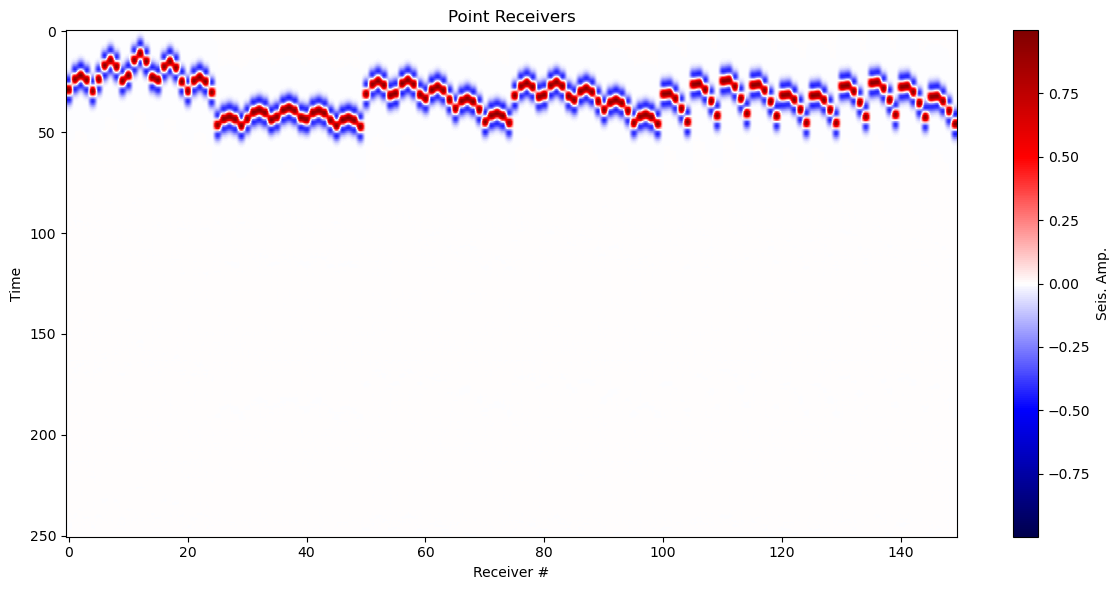

In [8]:
# PERFORM FORWARD (MODEL)
frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
fig,ax = traceimage(frwddata, climQ=99.99)
ax.set_title('Point Receivers')

# MIGRATE

In [9]:
migrated = (Op.H @ frwddata).reshape(nx,ny,nz)
hc =  get_max_locs(migrated, n_max=1, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(migrated,sx,sy)

AttributeError: 'tuple' object has no attribute 'flatten'

# INVERSION

In [ ]:
inv = (lsqr(Op, frwddata.ravel(), iter_lim=100, show=True)[0]).reshape(nx,ny,nz)
hc =  get_max_locs(inv, n_max=1, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(inv,sx,sy)

# PSEUDO-DAS

In [ ]:
nr_x = 5
pdas_recs = dasgeom(nxyz, dxyz)
pdas_data = rec2das_datatrnsfrm(frwddata, [nr_x, nr_x, nr_x], nt)
fig,ax = traceimage(pdas_data, climQ=99.99, cmap='seismic')
ax.set_title('Pseudo-DAS')

In [ ]:
SumStackOp = cubePDoperator(nr_x, nt)
pdasFrwdOp = SumStackOp * Op

In [ ]:
pdas_Ev = pdasFrwdOp @ microseismic.flatten()

In [ ]:
pdas_migration = (pdasFrwdOp.H @ pdas_Ev.ravel()).reshape(nx,ny,nz)
hc =  get_max_locs(pdas_migration, n_max=1, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(pdas_migration,sx,sy)

In [ ]:
pdas_lsqr = lsqr(pdasFrwdOp, pdas_Ev.flatten(), iter_lim=100, show=True)[0].reshape(nx,ny,nz)
hc =  get_max_locs(pdas_lsqr, n_max=1, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(pdas_lsqr,sx,sy)

In [ ]:
with pylops.disabled_ndarray_multiplication():
    pdas_fista = fista(pdasFrwdOp, pdas_Ev.flatten(), niter=100, eps=1e2, show=True)[0].reshape(nx,ny,nz)
hc =  get_max_locs(pdas_fista, n_max=1, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(pdas_fista,sx,sy)